# Sales Price Regression

In this notebook I use the data prepared in the prepare_sales_price_data and try to develop a model that can predict the sales price for a single-family detached homes in Fairfax County in 2023 based on its characteristics and location.

## Data Preparation

I limit the scope to single-family detached homes, built after 1900, with less than 6000 sq ft of living area, and that sold for under 1.5M. The age and square footage restriction only removed 3 sales, but removing these outliers drastically improved the performance of the linear regression model I started with.

After removing outliers and re-formatting categorical data (supervisor district and closest metro station) into one-hot encoded features I check for correlation between predictors. None of house characteristics have more than 0.9 correlation. However, the distances to various metro stations are sometimes highly correlated, which makes a lot of sense intuitively - picture two stations near each other, any step closer to one would also bring you closer to the other unless you were between the two. So, I also identify a set of stations for which the distance to station feature is not highly correlated for any pair.

Prior to model training the data is split into train and test sets. After exploring a few different regular linear regressions based on subsets of features I also standardize the training data and see if this leads to different results.

## Model Fitting

I explore a few different models in this notebook. Starting with linear regression, just out of curiousity and as a rough baseline I wanted to see how well an extremely simple linear regression just trying to predict sales price based solely on square feet of living area would do. Then I try a few different combinations of predictors in a regular multiple linear regression model. Next I train and evaluate a LASSO regression, KNN regression, and a random forest regressor

For each model that's trained I track Root Mean Squared Error on both the training set and test set. Any stark difference between the two could be a sign of over-fitting to the training data. The simple linear regression doesn't require tuning any specific parameters. For the LASSO and KNN regression models I use functionality provided in sklearn that uses cross validation to find the right values for the penalty coefficient for LASSO and the number of neighbors to use for KNN regression.

## Results

|model|	train_rmse|	test_rmse|
|---|---|---|
|Random Forest	|50138|	100798|
|Random Forest - Shallow | 85156 | 108404| 
|linear regression - scaled X|	111481|	111301|
|linear regression|	111481|	111301|
|KNN	|106860|	112229|
|Ridge regression|	113907|	112711|
|LASSO regression|	115319|	114611|

The Random Forest Model provides a notable improvement over the others, however it also has the largest gap by far between in sample and out of sample performance. I tried to address this with some cross-validation driven hyper parameter tuning but it was surprisingly ineffective, I might revisit and see if there's something I missed when implementing my cross validation tuning. As a quick fix I trained a Random Forest model with a slightly arbitrary smaller max depth, called Random Forest Shallow, that still gives better predictions on the test data than the linear models or the KNN model. Due to the smaller max depth it this model is less overfit to the training data, though the gap between train and test performance is still larger than with the linear models. 

The basic linear regression model - with or without standardizing the predictors - has the next best performance. This might make model selection a bit tricky - slightly better performance from the random forest model vs a slightly less performant simple regression that would be more explainable and doesn't have huge differences in train vs test performance.

## Conclusion

Overall, getting to a RMSE of around 100k is not terrible given the features used here. We have very general information about the structure of the house being sold as well as fairly robust data on location. What's missing is data giving a sense of the condition/presentability of the house. It's easy to imagine two houses with the same bedrooms/bathrooms/size on the same street selling for prices 100k different in Fairfax depending on the condition of the house itself and the quality of finishes, condition of the yard, and other factors not represented in our data. Also, time of year as well as more macro-economic factors, e.g. interest rate, could make a difference too, and these aren't in our data either. The caveat noted in the other notebook also still stands: this is a model based on 2023 transactions, extending it to account for a longer time horizon of sales and handle market-level trends intelligently could be an interesting follow on effort.

In [1]:
# Imports
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn import preprocessing, linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(style="darkgrid")
import matplotlib.pyplot as plt

In [2]:
# read data
df =  pd.read_csv("data/sales_and_features_2023.csv")

# limit scope to single family homes under 1.5M
df = df[df['luc_desc'] == 'Single-family, Detached']
df = df[df['price'] <= 1500000]
df = df[df['yrblt'] > 1900] # removes two outliers, houses built in the 18th and 19th century
df = df[df['sfla'] < 6000] # removes one observation

# fill blanks for half baths 
df['fixhalf'] = df['fixhalf'].fillna(0)

# add boolean columns for supervisor districts
df = df.join(pd.get_dummies(df['supervisor_district']))

# add boolean columns for closest stations
closest_station_bools = pd.get_dummies(df['closest_station'])
closest_station_bools.columns = [
    x.lower().replace(' ', '_').replace('-', '_').replace('/', '_') for x in closest_station_bools.columns
]
df = df.join(closest_station_bools)

Let's plot a pairplot and a heatmap of the correlation between the main predictors to explore their correlations. In general we don't want highly correlated predictors. We also have features giving the distance from each address to the different metro stations in Virginia, these will inevitably be highly correlated in some cases, we'll try to deal with this later on.

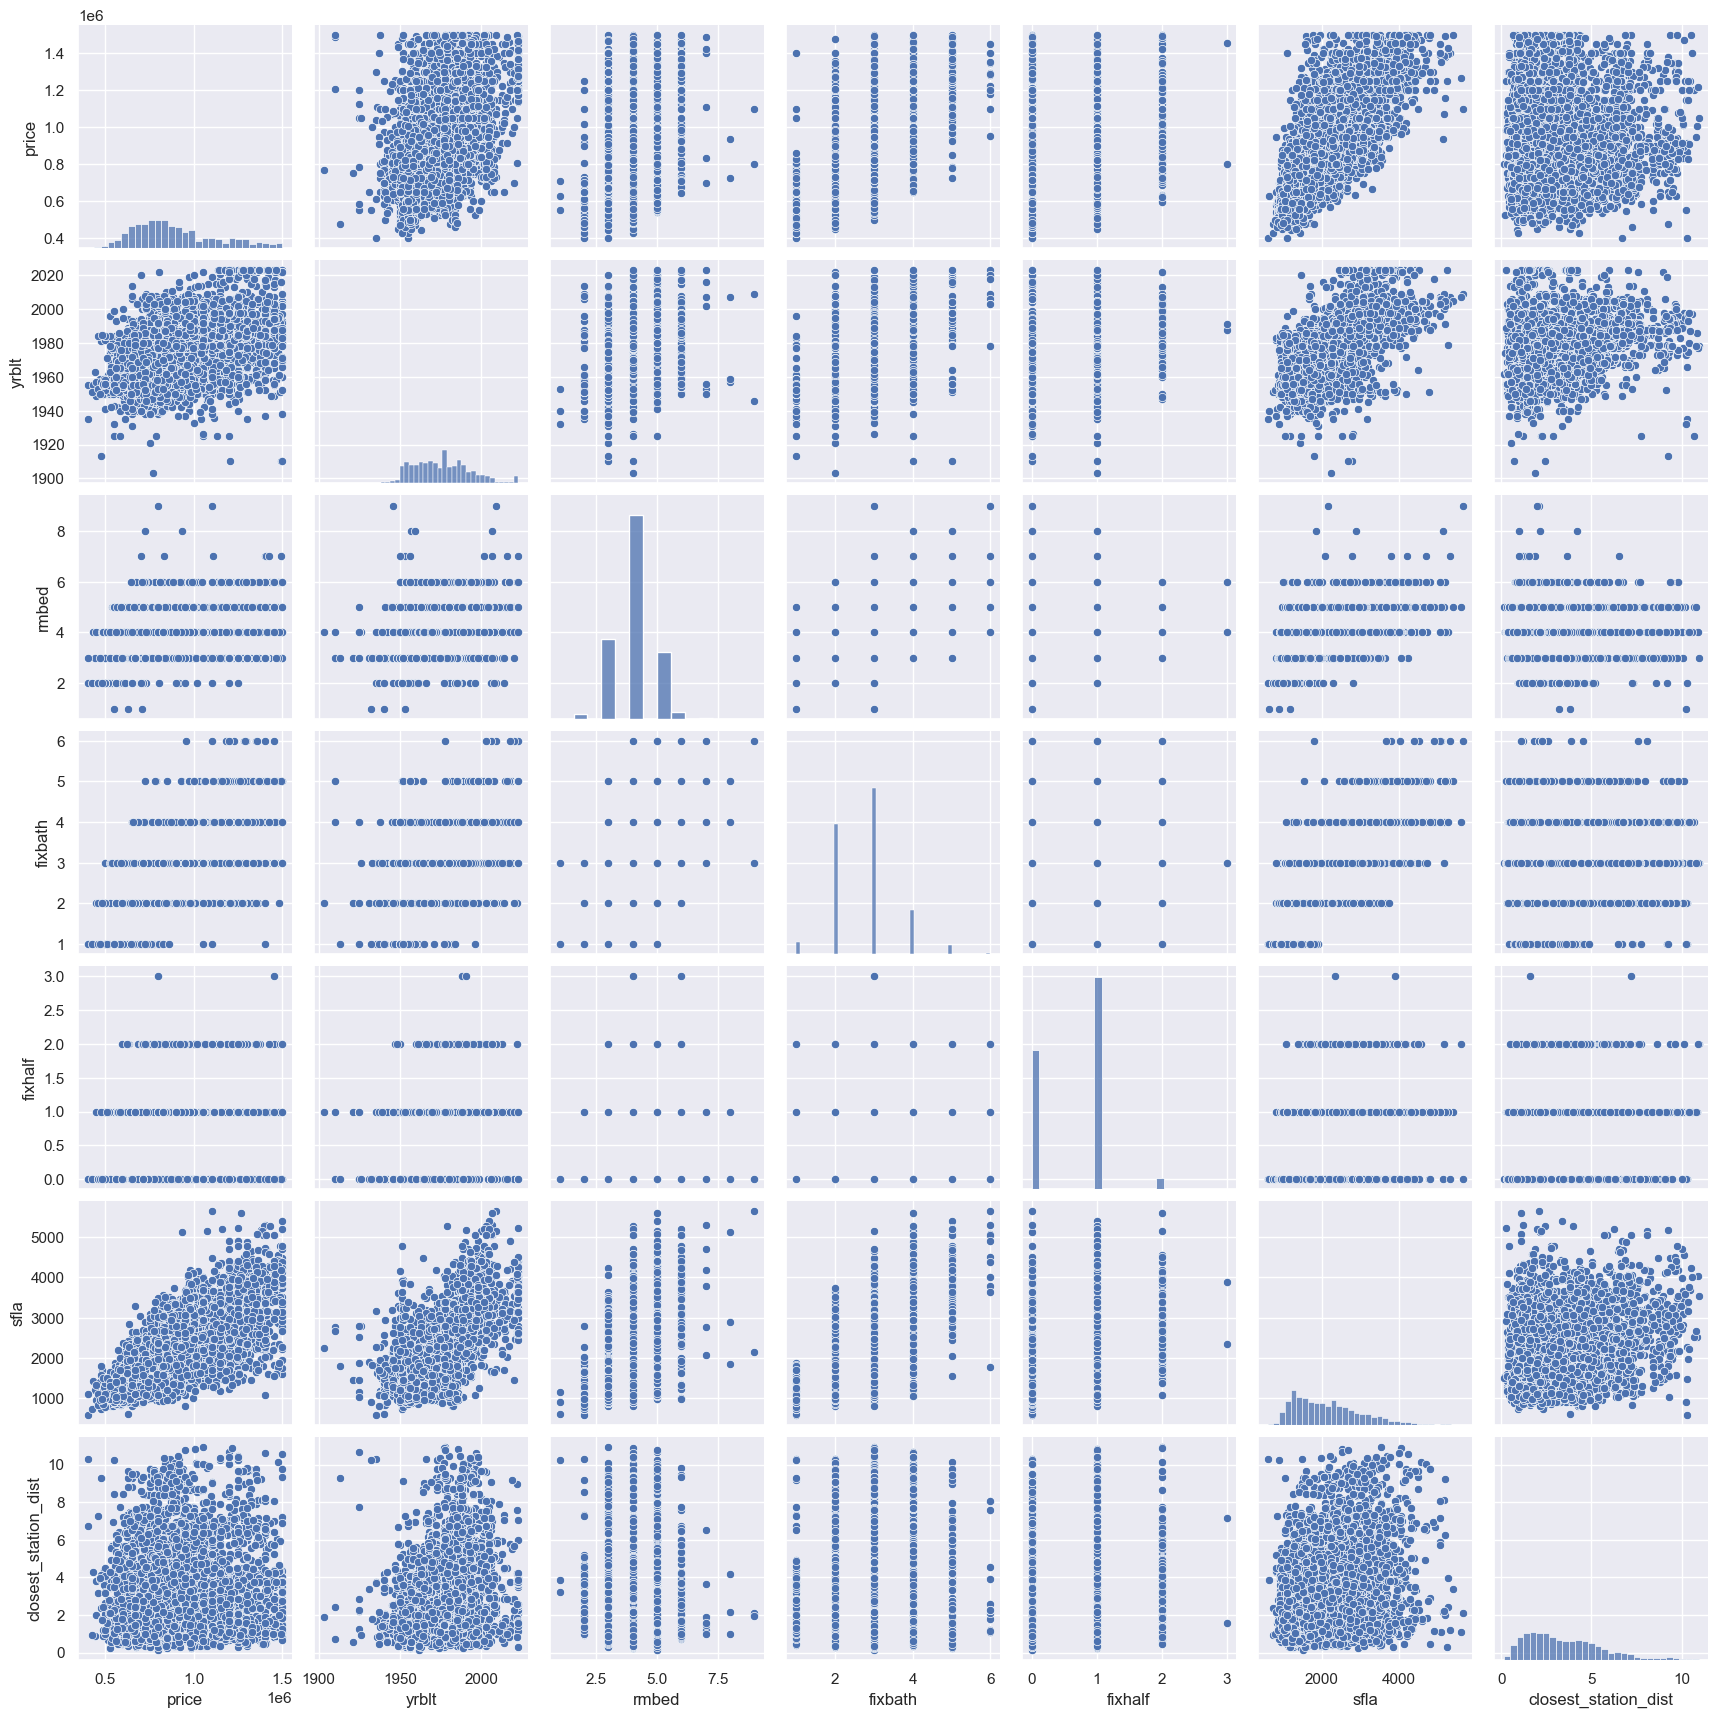

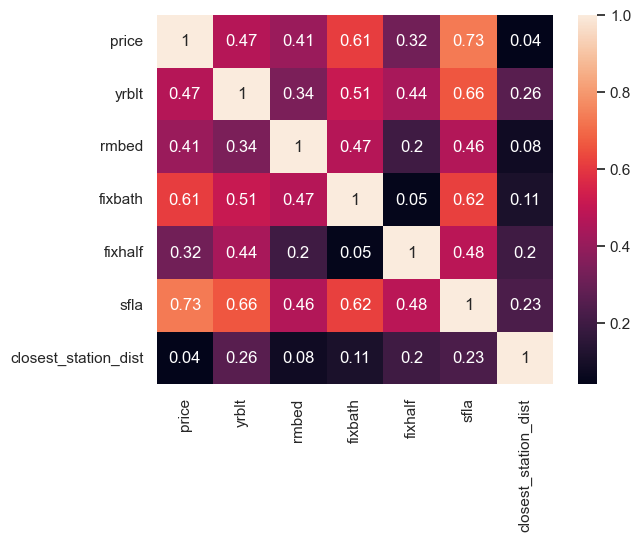

In [3]:
sns.pairplot(
       df[['price', 'yrblt', 'rmbed', 'fixbath', 'fixhalf', 'sfla', 'closest_station_dist']]
)
plt.show()

correlation_matrix = df[['price', 'yrblt', 'rmbed', 'fixbath', 'fixhalf', 'sfla', 'closest_station_dist']].corr().round(2)
# annot = True to print the values inside the square
sns.heatmap(data=correlation_matrix, annot=True)
plt.show()

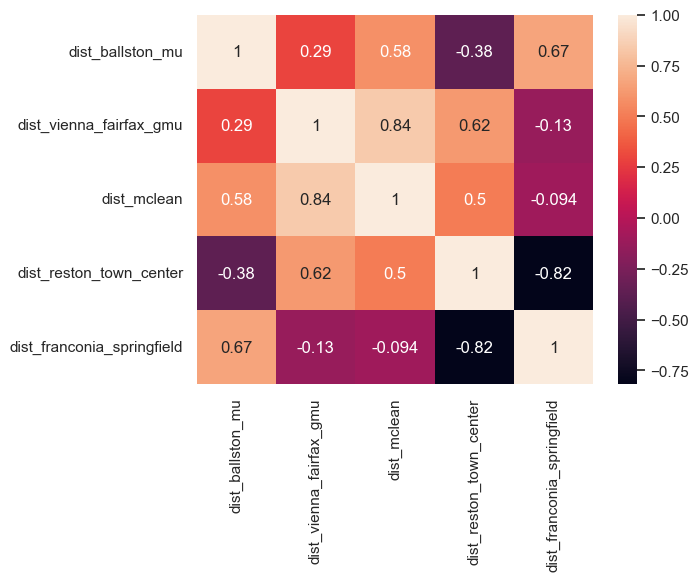

In [4]:

dist_correlation_matrix = df[['dist_ballston_mu', 'dist_vienna_fairfax_gmu', 'dist_mclean', 'dist_reston_town_center',
                              'dist_franconia_springfield']].corr().round(3)
sns.heatmap(data=dist_correlation_matrix, annot=True)
plt.show()

In [5]:
linear_model_performance = []

model_definitions = [
    {'name':'sfla_only', 'predictors':['sfla']},
    {'name':'basic', 'predictors':['yrblt', 'rmbed', 'fixbath', 'fixhalf', 'sfla']},
    {'name':'districts', 'predictors':['yrblt', 'rmbed', 'fixbath', 'fixhalf', 'sfla', 'BRADDOCK', 'DRANESVILLE', 'FRANCONIA', 
                                       'HUNTER MILL', 'MASON', 'MOUNT VERNON', 'PROVIDENCE', 'SPRINGFIELD', 'SULLY']},
    {'name':'closest_station', 'predictors':['yrblt', 'rmbed', 'fixbath', 'fixhalf', 'sfla', 'closest_station_dist']},
    {'name':'closest_station_and_district', 'predictors':['yrblt', 'rmbed', 'fixbath', 'fixhalf', 'sfla', 'closest_station_dist', 
                                                          'BRADDOCK', 'DRANESVILLE', 'FRANCONIA', 'HUNTER MILL', 'MASON', 'MOUNT VERNON', 
                                                          'PROVIDENCE', 'SPRINGFIELD', 'SULLY']},
    {'name':'select_stations_dist', 'predictors':['sfla', 'yrblt', 'rmbed', 'fixbath', 'fixhalf', 'dist_ballston_mu', 
                                                  'dist_vienna_fairfax_gmu', 'dist_mclean', 'dist_reston_town_center',
                                                  'dist_franconia_springfield']},
    {'name':'all_stations_dist', 
     'predictors':['yrblt', 'rmbed', 'fixbath', 'fixhalf', 'sfla', 'dist_arlington_cemetery', 'dist_ashburn', 'dist_ballston_mu', 
                   'dist_braddock_road', 'dist_clarendon', 'dist_court_house', 'dist_crystal_city', 'dist_dunn_loring_merrifield', 
                   'dist_east_falls_church', 'dist_eisenhower_avenue', 'dist_franconia_springfield', 'dist_greensboro', 'dist_herndon',
                   'dist_huntington', 'dist_innovation_center', 'dist_king_st_old_town', 'dist_loudoun_gateway', 'dist_mclean', 'dist_pentagon', 
                   'dist_pentagon_city', 'dist_potomac_yard', 'dist_reston_town_center', 'dist_ronald_reagan_washington_national_airport', 
                   'dist_rosslyn', 'dist_spring_hill', 'dist_tysons', 'dist_van_dorn_street', 'dist_vienna_fairfax_gmu', 'dist_virginia_square_gmu', 
                   'dist_washington_dulles_international_airport', 'dist_west_falls_church', 'dist_wiehle_reston_east']},
]

for model in model_definitions:
    X_train, X_test, y_train, y_test = train_test_split(
        df[model['predictors']].values, df[['price']].values.flatten(), test_size=0.33, random_state=123)

    regr = linear_model.LinearRegression()
    regr.fit(X_train, y_train)
    y_train_pred = regr.predict(X_train)
    y_test_pred = regr.predict(X_test)

    linear_model_performance.append({
        'model':model['name'], 
        'train_rmse':root_mean_squared_error(y_train, y_train_pred),
        'test_rmse':root_mean_squared_error(y_test, y_test_pred)
    })

,model,train_rmse,test_rmse
6,all_stations_dist,111481.835488,111301.682460
5,select_stations_dist,125455.679888,125375.218475
4,closest_station_and_district,141783.049749,137199.839603
2,districts,141946.612369,137753.235110
3,closest_station,151098.358704,145629.015660
1,basic,153216.275674,148587.884251
0,sfla_only,161335.743281,157502.079598


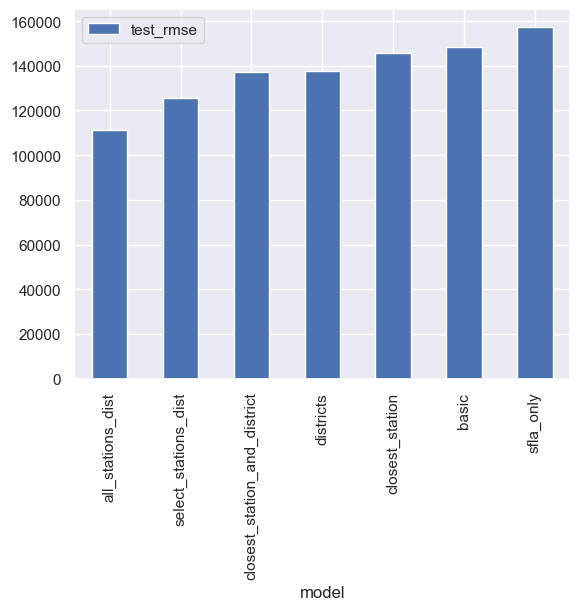

In [6]:
linear_model_performance_df = pd.DataFrame(linear_model_performance).sort_values(by=['test_rmse'])
display(linear_model_performance_df)
linear_model_performance_df.plot.bar(x='model', y='test_rmse')
plt.show()

In [7]:
model_performance = []

# selecting the model with the distances to all metro stations:
predictors = ['yrblt', 'rmbed', 'fixbath', 'fixhalf', 'sfla', 'dist_arlington_cemetery', 'dist_ashburn', 'dist_ballston_mu', 'dist_braddock_road', 
              'dist_clarendon', 'dist_court_house', 'dist_crystal_city', 'dist_dunn_loring_merrifield', 'dist_east_falls_church', 'dist_eisenhower_avenue', 
              'dist_franconia_springfield', 'dist_greensboro', 'dist_herndon', 'dist_huntington', 'dist_innovation_center', 'dist_king_st_old_town', 
              'dist_loudoun_gateway', 'dist_mclean', 'dist_pentagon', 'dist_pentagon_city', 'dist_potomac_yard', 'dist_reston_town_center', 
              'dist_ronald_reagan_washington_national_airport', 'dist_rosslyn', 'dist_spring_hill', 'dist_tysons', 'dist_van_dorn_street', 'dist_vienna_fairfax_gmu', 
              'dist_virginia_square_gmu', 'dist_washington_dulles_international_airport', 'dist_west_falls_church', 'dist_wiehle_reston_east']

X_train, X_test, y_train, y_test = train_test_split(
    df[predictors].values, df[['price']].values.flatten(), test_size=0.33, random_state=123
)

regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
y_train_pred = regr.predict(X_train)
y_test_pred = regr.predict(X_test)

model_performance.append({
    'model':'linear regression',
    'train_rmse': root_mean_squared_error(y_train, y_train_pred),
    'test_rmse':root_mean_squared_error(y_test, y_test_pred)
})

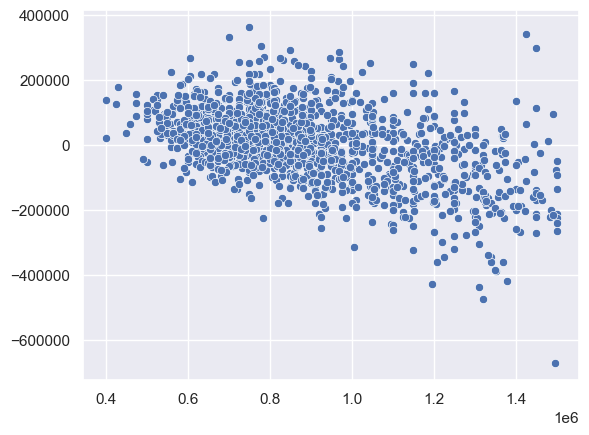

In [8]:
# let's look at the residuals
sns.scatterplot(x = y_test, y=y_test_pred-y_test)
plt.show()

In this case our residuals look heteroscedastic - they seem to show greater variance for more expensive sales. Let's try standardizing the features and see if that helps.

Scaled Features - Train RMSE: 111481.83548784058
Scaled Features - Test RMSE: 111301.68246018792


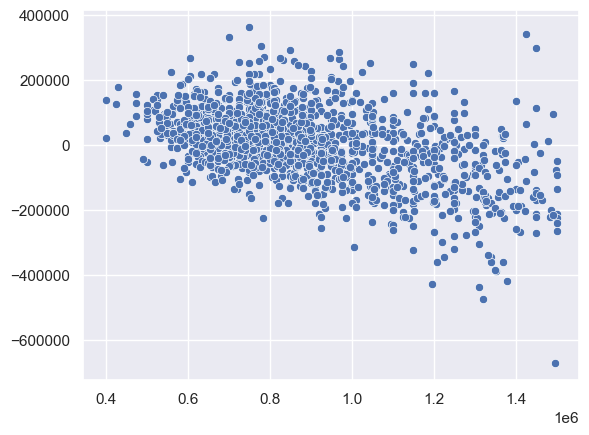

In [9]:
scaler = preprocessing.StandardScaler().fit(X_train)
scaled_X_train = scaler.transform(X_train)
scaled_X_test = scaler.transform(X_test)
regr_scaled = linear_model.LinearRegression()
regr_scaled.fit(scaled_X_train, y_train)
scaled_y_train_pred = regr_scaled.predict(scaled_X_train)
scaled_y_test_pred = regr_scaled.predict(scaled_X_test)
print("Scaled Features - Train RMSE: " + str(root_mean_squared_error(y_train, scaled_y_train_pred)))
print("Scaled Features - Test RMSE: " + str(root_mean_squared_error(y_test, scaled_y_test_pred)))
model_performance.append({
    'model':'linear regression - scaled X',
    'train_rmse': root_mean_squared_error(y_train, scaled_y_train_pred),
    'test_rmse':root_mean_squared_error(y_test, scaled_y_test_pred)
})
# let's look at the residuals again
sns.scatterplot(x = y_test, y=y_test_pred-y_test)
plt.show()

In this case it looks like scaling the predictors had no discernable impact on the residuals - they're still heteroscedastic. This might not be a huge concern if the test RMSE is still good and the goal for the model is prediction.

Let's also try training some penalized linear models, LASSO and Ridge regression models, to see if they give better performance than a regular linear regression. For completeness I also want to check if they show less heteroscedasticity though this is just a secondary concern.

alpha parameter recommended through cross validation: 171.6662611691556
LASSO - Train RMSE: 115319.4725890693
LASSO - Test RMSE: 114611.13697686518


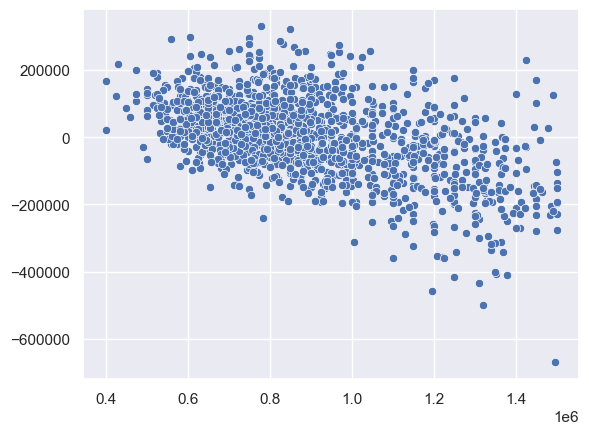

In [10]:
model = linear_model.LassoCV(cv=10, random_state=123, max_iter=10000)
model.fit(scaled_X_train, y_train)

# the 10-fold cross validation recommends an alpha parameter of 171.9
print("alpha parameter recommended through cross validation: " + str(model.alpha_))

# had to specify a larger max_iter param to prevent a convergence warning
regr_lasso = linear_model.Lasso(alpha=model.alpha_, max_iter=10000) #tol=0.052, max_iter=10000
regr_lasso.fit(scaled_X_train, y_train)
lasso_y_train_pred = regr_lasso.predict(scaled_X_train)
lasso_y_test_pred = regr_lasso.predict(scaled_X_test)
print("LASSO - Train RMSE: " + str(root_mean_squared_error(y_train, lasso_y_train_pred)))
print("LASSO - Test RMSE: " + str(root_mean_squared_error(y_test, lasso_y_test_pred)))
model_performance.append({
    'model':'LASSO regression',
    'train_rmse': root_mean_squared_error(y_train, lasso_y_train_pred),
    'test_rmse':root_mean_squared_error(y_test, lasso_y_test_pred)
})

# let's look at the residuals again
sns.scatterplot(x = y_test, y=lasso_y_test_pred-y_test)
plt.show()

alpha parameter recommended by cross validation: 0.1
Ridge - Train RMSE: 113907.70956542985
Ridge - Test RMSE: 112711.40855082331


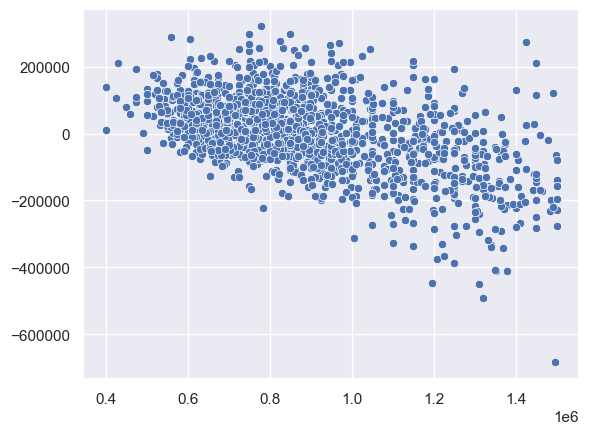

In [11]:
model = linear_model.RidgeCV(cv=10)
model.fit(scaled_X_train, y_train)
print("alpha parameter recommended by cross validation: " + str(model.alpha_))
regr_ridge = linear_model.Ridge(alpha=model.alpha_)
regr_ridge.fit(scaled_X_train, y_train)
ridge_y_train_pred = regr_ridge.predict(scaled_X_train)
ridge_y_test_pred = regr_ridge.predict(scaled_X_test)
print("Ridge - Train RMSE: " + str(root_mean_squared_error(y_train, ridge_y_train_pred)))
print("Ridge - Test RMSE: " + str(root_mean_squared_error(y_test, ridge_y_test_pred)))
model_performance.append({
    'model':'Ridge regression',
    'train_rmse': root_mean_squared_error(y_train, ridge_y_train_pred),
    'test_rmse':root_mean_squared_error(y_test, ridge_y_test_pred)
})

# let's look at the residuals again
sns.scatterplot(x = y_test, y=ridge_y_test_pred-y_test)
plt.show()

Comparing the three linear models, all have roughly similar performance, with the regular linear regression producing the lowest test RMSE. The test RMSE and training RMSE are also closest to each other in the regular linear model, though across all three models the test RMSE ends up lower than the training RMSE. Of these three options, the regular linear regression model seems to be the most performant.

Let's try a couple different non-linear models as well and evaluate their performance in predicting sales prices - K Nearest Neighbors and Random Forest Regressors

In [12]:

knn = KNeighborsRegressor()
param_grid = {'n_neighbors': np.arange(1, 25)}
knn_gscv = GridSearchCV(knn, param_grid, cv=10)
knn_gscv.fit(scaled_X_train, y_train)
print("number of neighbors recommended by grid search" + str(knn_gscv.best_params_))
neigh = KNeighborsRegressor(n_neighbors=11)
neigh.fit(scaled_X_train, y_train)
neigh_y_train_pred = neigh.predict(scaled_X_train)
neigh_y_test_pred = neigh.predict(scaled_X_test)
print("KNN - Train RMSE: " + str(root_mean_squared_error(y_train, neigh_y_train_pred)))
print("KNN - Test RMSE: " + str(root_mean_squared_error(y_test, neigh_y_test_pred)))
model_performance.append({
    'model':'KNN',
    'train_rmse': root_mean_squared_error(y_train, neigh_y_train_pred),
    'test_rmse':root_mean_squared_error(y_test, neigh_y_test_pred)
})

number of neighbors recommended by grid search{'n_neighbors': 11}
KNN - Train RMSE: 106860.21121000868
KNN - Test RMSE: 112229.28593219897


In [14]:
# credit: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
max_depth = [int(x) for x in np.linspace(5, 20, num = 5)]
max_depth.append(None)
min_samples_split = [4, 10]
min_samples_leaf = [2, 4, 10]
random_grid = {
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
print(random_grid)

rfr = RandomForestRegressor(n_estimators=1000, max_features='sqrt')
# removed:  verbose=2
rf_random = RandomizedSearchCV(
    estimator = rfr, 
    param_distributions = random_grid, 
    n_iter = 20, 
    cv = 5, 
    random_state=123, 
    n_jobs = -1,
    scoring="neg_mean_squared_error"
)
rf_random.fit(scaled_X_train, y_train)

{'max_depth': [5, 8, 12, 16, 20, None], 'min_samples_split': [4, 10], 'min_samples_leaf': [2, 4, 10]}


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(max_features='sqrt',
                                                   n_estimators=1000),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'max_depth': [5, 8, 12, 16, 20, None],
                                        'min_samples_leaf': [2, 4, 10],
                                        'min_samples_split': [4, 10]},
                   random_state=123, scoring='neg_mean_squared_error')

In [15]:
rf_random.best_params_

{'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 20}

In [16]:
np.sqrt(-1*rf_random.best_score_)

102669.03631007581

In [17]:
rfr_y_train_pred = rf_random.predict(scaled_X_train)
rfr_y_test_pred = rf_random.predict(scaled_X_test)
print("Random Forest - Train RMSE: " + str(root_mean_squared_error(y_train, rfr_y_train_pred)))
print("Random Forest - Test RMSE: " + str(root_mean_squared_error(y_test, rfr_y_test_pred)))
model_performance.append({
    'model':'Random Forest',
    'train_rmse': root_mean_squared_error(y_train, rfr_y_train_pred),
    'test_rmse':root_mean_squared_error(y_test, rfr_y_test_pred)
})

Random Forest - Train RMSE: 50138.25630519873
Random Forest - Test RMSE: 100798.69391520212


Tuning hyperparameters with randomized search cross validation produced a model with a much lower train RMSE than test RMSE, indicating that the model was overfitted to the training data. This is a bit unexpected because cross validation is typically supposed to reduce difference between test and train performance.

To try and address this I adjusted to different max depths that were on the shallower side to try and find a model with less of a difference between train and test RMSE.

In the future I might revisit this and try to improve the set up of the cross-validation function to see if it can be tweaked to do a better job at preventing over-fitting. I also tried using GridSearchCV but it was quite slow for more exhaustive parameter grids, if I have more time later on I might see if that can be used - with better cross-validation arguments - to try and find a better Random Forest Regressor Model.

In [18]:
rfr_shallow = RandomForestRegressor(n_estimators=1000, max_features='sqrt', min_samples_leaf=2, min_samples_split=4, max_depth=8)
rfr_shallow.fit(scaled_X_train, y_train)

RandomForestRegressor(max_depth=8, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=4, n_estimators=1000)

In [19]:
rfr_s_y_train_pred = rfr_shallow.predict(scaled_X_train)
rfr_s_y_test_pred = rfr_shallow.predict(scaled_X_test)
print("Random Forest - Train RMSE: " + str(root_mean_squared_error(y_train, rfr_s_y_train_pred)))
print("Random Forest - Test RMSE: " + str(root_mean_squared_error(y_test, rfr_s_y_test_pred)))
model_performance.append({
    'model':'Random Forest - Shallow',
    'train_rmse': root_mean_squared_error(y_train, rfr_s_y_train_pred),
    'test_rmse':root_mean_squared_error(y_test, rfr_s_y_test_pred)
})

Random Forest - Train RMSE: 85156.73661410133
Random Forest - Test RMSE: 108404.29334752471


,model,train_rmse,test_rmse
5,Random Forest,50138.256305,100798.693915
6,Random Forest - Shallow,85156.736614,108404.293348
1,linear regression - scaled X,111481.835488,111301.682460
0,linear regression,111481.835488,111301.682460
4,KNN,106860.211210,112229.285932
3,Ridge regression,113907.709565,112711.408551
2,LASSO regression,115319.472589,114611.136977


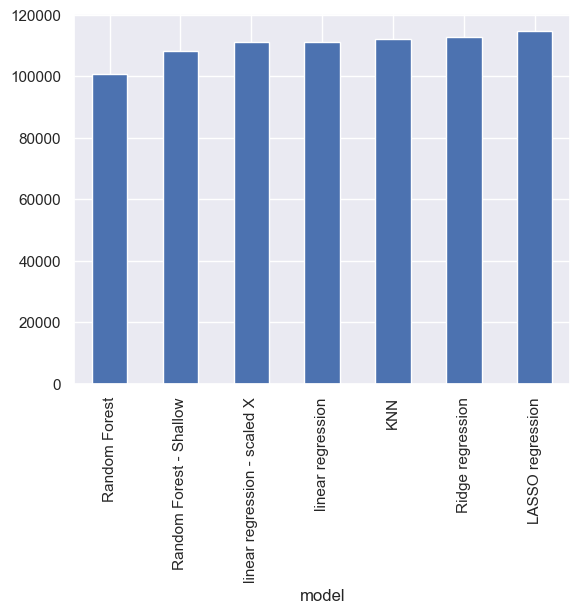

In [20]:
model_performance_df = pd.DataFrame(model_performance).sort_values(by=['test_rmse'])
display(model_performance_df)
model_performance_df.plot.bar(x='model', y='test_rmse', legend=False)
# plt.ylim(90000, 120000)
plt.show()